In [ ]:
# # 베이스 구글 드라이브 폴더 설정
# RUN_GDRIVE_PATH = "lecture_"

# 1.사전 준비

## 1.1. Imports

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Base libraries
import os
import random

# Keras libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, Softmax
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.8.2


## 1.2.유틸

In [ ]:
def save_model(model_name: str, model: keras.models.Model):
    model_json = model.to_json()
    with open(model_name, "w") as json_file:
        json_file.write(model_json)

from keras.models import model_from_json
from typing import Optional

In [ ]:
def load_model(
    model_name: str, with_weights_path: Optional[str] = None
) -> keras.models.Model:
    json_file = open(model_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    if with_weights_path:
        model.load_weights(with_weights_path)
    return model

## 1.3.구글 드라이브 설정

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

여러분의 설정한 구글 드라이브의 폴더 이름을 넣습니다.

In [ ]:
# import os
# base_gdrive_path = os.path.join("drive", "MyDrive", RUN_GDRIVE_PATH)

설정한 구글 드라이브 폴더의 하위에 `results` 라는 이름의 폴더를 설정합니다.

In [ ]:
# from pathlib import Path
# import os

# result_path = os.path.join(base_gdrive_path, "results")
# Path(result_path).mkdir(parents=True, exist_ok=True)

# 2.CamVid Dataset

https://figshare.com/articles/dataset/camvid/17080916 이 사이트에서 자료를 받습니다. (아래 줄을 실행하시면 받을 수 있습니다.)


파일(186MB)에 대한 직접적인 링크는 아래와 같습니다.

https://figshare.com/ndownloader/files/31579223 


In [ ]:
!wget -q https://figshare.com/ndownloader/files/31579223 -O CamVid.zip
!unzip -qq CamVid.zip

마스크 라벨 등에 대한 설명이 필요하다면 다음 링크를 참고합니다.

https://www.kaggle.com/datasets/carlolepelaars/camvid

## 2.1.가져오기

CamVid는 tfds에 없으므로, 직접 만들어야 합니다.


| 구분 | 개수 |
| --- | --- |
|'test'|233|
|'val'|101|
|'train'|367|


In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
def read_image(image_path: str, as_grayscale: bool = False) -> tf.Tensor:
    """경로에 있는 (단일) 이미지 읽기.

    `tf.float32` 타입의 `[None, None, 1]` (`as_grayscale`이 True인 경우) 혹은 `[None, None, 3]` (`as_grayscale`이 False인 경우) 이미지 텐서를 리턴한다.

    Parameters
    ----------
    image_path : str
        이미지를 읽을 경로.
    as_grayscale : bool, optional
        흑백 이미지로 읽을 여부, by default False

    Returns
    -------
    tf.Tensor
        `tf.float32` 타입의 `[None, None, 1]` (`as_grayscale`이 True인 경우) 혹은 `[None, None, 3]` (`as_grayscale`이 False인 경우) 이미지 텐서.
    """
    image = tf.io.read_file(image_path)
    color_channel = 3 if not as_grayscale else 1
    image = tf.image.decode_png(image, channels=color_channel)
    image.set_shape([None, None, color_channel])
    image = tf.cast(image, dtype=tf.float32)
    return image

In [ ]:
from typing import List

def path_to_image_file_list(path_glob_pattern: str) -> List[str]:
    from glob import glob
    return sorted(glob(path_glob_pattern))

In [ ]:
def resize_img(image: tf.Tensor, image_hw_size: int) -> tf.Tensor:
    

def resize_mask_img(image: tf.Tensor, image_hw_size: int) -> tf.Tensor:
    

In [ ]:
train_image_path = "/content/Camvid/train"
train_mask_path = "/content/Camvid/trainannot"

val_image_path = "/content/Camvid/val"
val_mask_path = "/content/Camvid/valannot"

test_image_path = "/content/Camvid/test"
test_mask_path = "/content/Camvid/testannot"

In [ ]:
import os
from typing import Optional

def semantic_segmentation_dataset_generator(
    image_path: str, 
    mask_path: str,
    image_extension: str = "*.png",
    mask_extension: str = "*.png",
    shuffle_global: bool = True,
    shuffle_global_random_seed: Optional[int] = None,
) -> tf.data.Dataset :
    # 파일 목록 --->
    image_files = path_to_image_file_list(os.path.join(image_path, image_extension))  # type: List[str]
    mask_files = path_to_image_file_list(os.path.join(mask_path, mask_extension))  # type: List[str]

    # 필터링
    # 마스크에는 이미지 파일과 (동일한 이름의 그레이스케일 마스크), 다른 이름의 흑백 마스크 및 컬러 마스크가 있는데,
    # 그 중에서 그레이스케일 마스크만 가져옵니다.
    image_files_names = sorted(list(map(lambda el: el[el.rfind("/")+1:], image_files)))
    mask_files = sorted(list(filter(lambda el: el[el.rfind("/")+1:] in image_files_names, mask_files)))

    # 파일 목록 셔플
    if shuffle_global:
        if shuffle_global_random_seed is None:
            shuffle_global_random_seed = np.random.randint(1e6)
        rng = np.random.RandomState(shuffle_global_random_seed)
        rng.shuffle(image_files)
        rng = np.random.RandomState(shuffle_global_random_seed)
        rng.shuffle(mask_files)
    # <--- 파일 목록

    # TF 데이터 세트 --->
    # 이미지 데이터 세트 -->
    # 이미지 파일 목록 데이터 세트 생성
    image_dataset = tf.data.Dataset.from_tensor_slices(image_files)  # type: tf.data.Dataset
    # 이미지 가져오기
    image_dataset = image_dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    # 리사이즈
    image_dataset = image_dataset.map(lambda image: resize_img(image, 256))
    # 정규화
    image_dataset = image_dataset.map(
        lambda img: img / 255.0,
        num_parallel_calls=tf.data.AUTOTUNE)
    # <-- 이미지 데이터 세트

    # 마스크 데이터 세트 -->
    # 마스크 파일 목록 데이터 세트 생성
    mask_dataset = tf.data.Dataset.from_tensor_slices(mask_files)  # type: tf.data.Dataset
    # 마스크 가져오기
    mask_dataset = mask_dataset.map(
        lambda mask_file: read_image(mask_file, True), 
        num_parallel_calls=tf.data.AUTOTUNE)
    # 리사이즈
    mask_dataset = mask_dataset.map(lambda mask: resize_mask_img(mask, 256))
    # <-- 마스크 데이터 세트
    
    return tf.data.Dataset.zip((image_dataset, mask_dataset))


In [ ]:
train_dataset = semantic_segmentation_dataset_generator(train_image_path, train_mask_path)
val_dataset = semantic_segmentation_dataset_generator(val_image_path, val_mask_path)
test_dataset = semantic_segmentation_dataset_generator(test_image_path, test_mask_path)

## 2.2.단일 데이터 살펴보기

데이터 세트 하나를 가져와서 살펴봅니다.

In [ ]:
sample_data = list(train_dataset.take(1))[0]

In [ ]:
sample_data

(<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
 array([[[0.82338774, 0.7957797 , 0.8282169 ],
         [0.649349  , 0.5938343 , 0.66967297],
         [0.91292506, 0.89303386, 0.9095014 ],
         ...,
         [0.3870634 , 0.38314185, 0.3752987 ],
         [0.38481158, 0.38089   , 0.37304688],
         [0.38463542, 0.38463542, 0.37679228]],
 
        [[0.8732498 , 0.844447  , 0.9047449 ],
         [0.7181679 , 0.66790366, 0.7579657 ],
         [0.9518497 , 0.93125767, 0.95426244],
         ...,
         [0.39744943, 0.39352787, 0.38568473],
         [0.39109606, 0.3871745 , 0.37933135],
         [0.38543963, 0.38543963, 0.3775965 ]],
 
        [[0.9305798 , 0.91644454, 0.9307751 ],
         [0.83204657, 0.7905905 , 0.8386259 ],
         [0.98029643, 0.97734374, 0.9795726 ],
         ...,
         [0.40559897, 0.4016774 , 0.39383426],
         [0.39955193, 0.39563036, 0.38778722],
         [0.38447073, 0.38440946, 0.37656632]],
 
        ...,
 
        [[0.19937576, 0.20329733

In [ ]:
tf.unique_with_counts(tf.reshape(sample_data[1], (-1, )))

UniqueWithCounts(y=<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([ 5.,  0., 11.,  2.,  1.,  6.,  7.,  9.,  8.,  4.,  3.],
      dtype=float32)>, idx=<tf.Tensor: shape=(65536,), dtype=int32, numpy=array([ 0,  0,  0, ..., 10, 10, 10], dtype=int32)>, count=<tf.Tensor: shape=(11,), dtype=int32, numpy=
array([ 4098, 12422,   622,   513, 14052,   362,  8563,   971,  3200,
        3598, 17135], dtype=int32)>)

마스크 값들의 분포를 전체 트레이닝 데이터에 걸쳐 살펴봅시다.

In [ ]:
all_data = list(train_dataset)
all_mask_data = np.array(list(map(lambda el: el[1].numpy(), all_data)))

In [ ]:
all_mask_data.shape

(367, 256, 256, 1)

In [ ]:
np.unique(all_mask_data)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
      dtype=float32)

1. 이미지 - (height, width, 3)
    - RGB 컬러 이미지
2. 마스크 - (height, width, 1)
    - 0, 1, 2, 3, ..., 11로 구성된 마스크
        - 0  : 
        - 1  :
        - 2  : 
        - 3  :
        - 4  : 
        - 5  :
        - 6  : 
        - 7  :
        - 8  : 
        - 9  :
        - 10 : 
        - 11 :
         

# 3.전처리

전처리는 앞에서 다 진행하였습니다.

1) 샘플 보기

In [ ]:
sample_image_1, sample_mask_1 = list(train_dataset.take(2))[1]

In [ ]:
import matplotlib.pyplot as plt

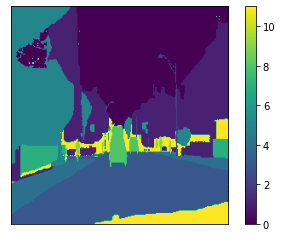

In [ ]:
# 이미지 플롯
plt.figure()
plt.imshow(tf.squeeze(sample_mask_1))
plt.colorbar()
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

# 4.U-Net

## 4.1.모델

In [ ]:
# U-Net
def unet(sz=(256, 256, 3), class_num: int=2):
  base_num_filter = 16

  input = Input(sz)
  
  # Encoding
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(input)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  skip1 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  skip2 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  skip3 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  skip4 = x

  x = MaxPooling2D()(x)
  
  # BottleNeck
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  
  # Decoding
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip4])
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip3])
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip2])
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip1])
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  
  output = Conv2D(class_num, 1, activation='sigmoid' if class_num == 1 else 'softmax')(x)
  
  # model creation
  model = Model(inputs=[input], outputs=[output])
  
  return model

In [ ]:
CLASS_NUM = 12

model = unet(class_num=CLASS_NUM)
model.compile(
    optimizer='rmsprop', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
    # metrics=[tf.keras.metrics.MeanIoU(num_classes=CLASS_NUM)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

## 4.2.모델 트레이닝

In [ ]:
# inheritance for training process plot 
import cv2

class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1

        # [선택] 랜덤으로 검증 이미지 선택
        val_sample_img, val_sample_mask = list(val_dataset.shuffle(1000).take(1))[0]
        
        # [예측] 선택된 이미지에 대해 예측
        pred = model.predict(np.expand_dims(val_sample_img, 0))
        
        # [후처리] 예측 결과 후처리
        msk = tf.squeeze(pred)
        msk = tf.argmax(msk, axis=-1)[..., tf.newaxis]
        
        # 디스플레이
        f, axarr = plt.subplots(1, 3, figsize=(16, 6))
        axarr[0].axis('off')
        axarr[1].axis('off')
        axarr[2].axis('off')
        axarr[0].imshow(tf.cast(val_sample_img*255.0, tf.uint8))
        axarr[0].set_title('Image')
        axarr[1].imshow(tf.squeeze(msk))
        axarr[1].set_title('Predicted')
        axarr[2].imshow(tf.squeeze(tf.cast(val_sample_mask, tf.uint8)))
        axarr[2].set_title('Target')
        plt.show()


In [ ]:
def build_callbacks():
    checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
    callbacks = [checkpointer, PlotLearning()]
    return callbacks


데이터 세트 배치로 전환

In [ ]:
BATCH_SIZE = 8

In [ ]:
batched_train_ds_1 = train_dataset.shuffle(1000).batch(BATCH_SIZE)
batched_val_ds_1 = val_dataset.batch(BATCH_SIZE)
batched_test_ds_1 = test_dataset.batch(BATCH_SIZE)

In [ ]:
history = model.fit(batched_train_ds_1, 
                    epochs=100, 
                    callbacks = build_callbacks(), 
                    validation_data=batched_val_ds_1)

Output hidden; open in https://colab.research.google.com to view.

[0.2990182638168335, 0.38181576132774353, 0.4996436536312103, 0.4393748342990875, 0.5697171092033386, 0.5981091260910034, 0.6260995268821716, 0.6471557021141052, 0.6601868867874146, 0.6735884547233582, 0.6703581809997559, 0.6836821436882019, 0.6862225532531738, 0.7119227647781372, 0.7119140028953552, 0.737541675567627, 0.7358577847480774, 0.7505965232849121, 0.7661336660385132, 0.7761017680168152, 0.7747844457626343, 0.7858082056045532, 0.7848169207572937, 0.7936370372772217, 0.8067092299461365, 0.8136506676673889, 0.8251420259475708, 0.8268346190452576, 0.8317084312438965, 0.8411884903907776, 0.8391216993331909, 0.8500625491142273, 0.841641902923584, 0.8485602140426636, 0.855143129825592, 0.8576825857162476, 0.8565019965171814, 0.8637234568595886, 0.8647428750991821, 0.868603527545929, 0.8659548163414001, 0.870185375213623, 0.8746607303619385, 0.8751408457756042, 0.8834958672523499, 0.8788018226623535, 0.8844519853591919, 0.8842540383338928, 0.8884199261665344, 0.8890562057495117, 0.8

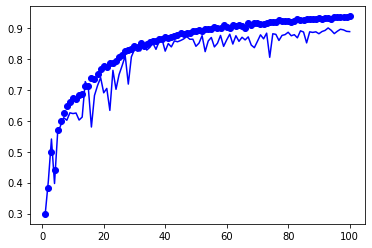

In [ ]:
history_accuracy = history.history["accuracy"]
history_val_accuracy = history.history["val_accuracy"]

epochs = range(1, len(history_accuracy) + 1)
plt.plot(epochs, history_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_val_accuracy, "b", label="Validation accuracy")

print(history_accuracy)
print(history_val_accuracy)

[1.9796229600906372, 1.6529313325881958, 2.1801254749298096, 1.5295684337615967, 1.349360466003418, 1.227069616317749, 1.1345123052597046, 1.0561708211898804, 0.9916574954986572, 0.9915478825569153, 0.9211859703063965, 0.9442426562309265, 0.8419033288955688, 0.8582708835601807, 0.806342363357544, 0.7970947027206421, 0.7635337710380554, 0.712649405002594, 0.686823308467865, 0.6839636564254761, 0.6717239022254944, 0.6827190518379211, 0.6491538286209106, 0.6142928600311279, 0.5917771458625793, 0.5640815496444702, 0.558873176574707, 0.5454374551773071, 0.5246899127960205, 0.525960385799408, 0.4956169128417969, 0.5159958600997925, 0.4902990758419037, 0.47357022762298584, 0.4673175811767578, 0.4665566086769104, 0.4411718249320984, 0.43728703260421753, 0.4288482367992401, 0.43721556663513184, 0.41753748059272766, 0.4033598005771637, 0.399687796831131, 0.3751979470252991, 0.3930853605270386, 0.3718685507774353, 0.37138959765434265, 0.3593783676624298, 0.36074724793434143, 0.3446628749370575, 0

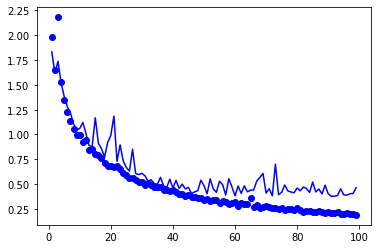

In [ ]:
history_loss = history.history["loss"][1:]
history_val_loss = history.history["val_loss"][1:]

epochs = range(1, len(history_loss) + 1)
plt.plot(epochs, history_loss, "bo", label="Training loss")
plt.plot(epochs, history_val_loss, "b", label="Validation loss")

print(history_loss)
print(history_val_loss)

## 4.3.모델 테스트 및 예측

In [ ]:
test_loss, test_acc = model.evaluate(batched_test_ds_1)
print('테스트 정확도:', test_acc)

30/30 [==============================] - 4s 134ms/step - loss: 0.8913 - accuracy: 0.8049
테스트 정확도: 0.8049036860466003


In [ ]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2022-08-10 02:23:03--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.33.88.38, 13.33.88.118, 13.33.88.57, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.33.88.38|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K   128KB/s    in 0.5s    

2022-08-10 02:23:04 (128 KB/s) - ‘test.jpg’ saved [63219/63219]



In [ ]:
import cv2
img = cv2.imread('test.jpg')
img.shape

(720, 720, 3)

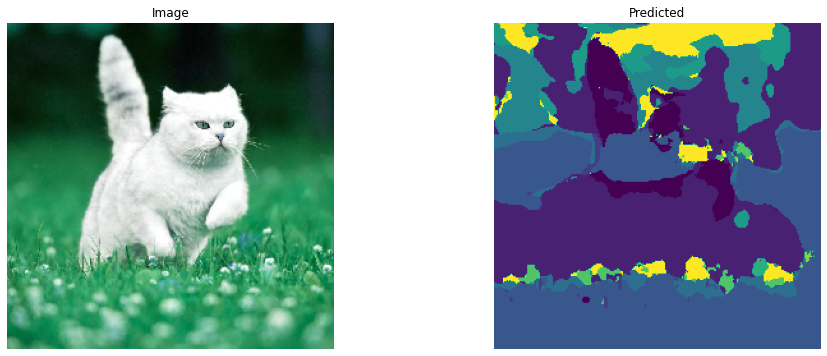

In [ ]:
# [선택] 랜덤으로 검증 이미지 선택
img = cv2.imread('test.jpg')
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
img = img / 255.

# [예측] 선택된 이미지에 대해 예측
pred = model.predict(np.expand_dims(img, 0))

# [후처리] 예측 결과 후처리
msk = tf.squeeze(pred)
msk = tf.argmax(msk, axis=-1)[..., tf.newaxis]

# 디스플레이
f, axarr = plt.subplots(1, 2, figsize=(16, 6))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[0].imshow(tf.cast(img*255.0, tf.uint8))
axarr[0].set_title('Image')
axarr[1].imshow(tf.squeeze(msk))
axarr[1].set_title('Predicted')
plt.show()